In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import dwave_networkx as dnx
from music21 import stream, converter, instrument, tinyNotation, environment
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
us['musicxmlPath']

from colours import Tableau as T

plt.style.use("thesis.mplstyle")

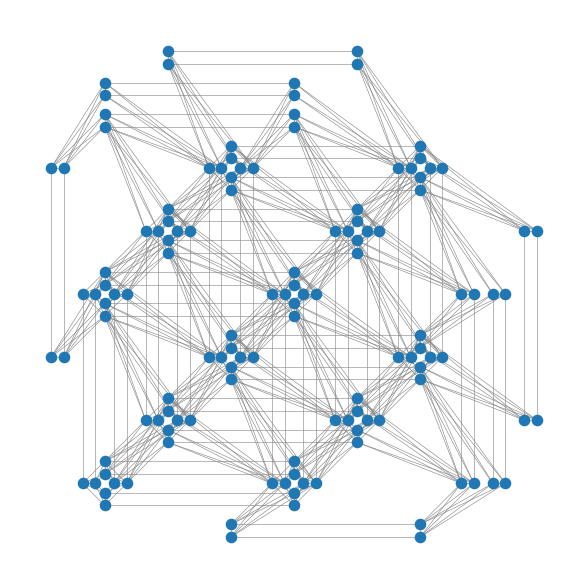

In [3]:
# Pegasus architecture

P = dnx.pegasus_graph(3)
#fig, ax = plt.subplots(layout="constrained")
dnx.draw_pegasus(P, with_labels=False, node_size = 10, width=0.2, crosses=True, node_color="tab:blue", edge_color="gray")
plt.gca().set_aspect('equal')
#plt.savefig("..\Figures\pegasus.pdf")

In [ ]:
class ColorModifier(tinyNotation.Modifier):
    def postParse(self, m21Obj):
        m21Obj.style.color = self.modifierData
        return m21Obj

tnc = tinyNotation.Converter()
tnc.modifierAngle = ColorModifier

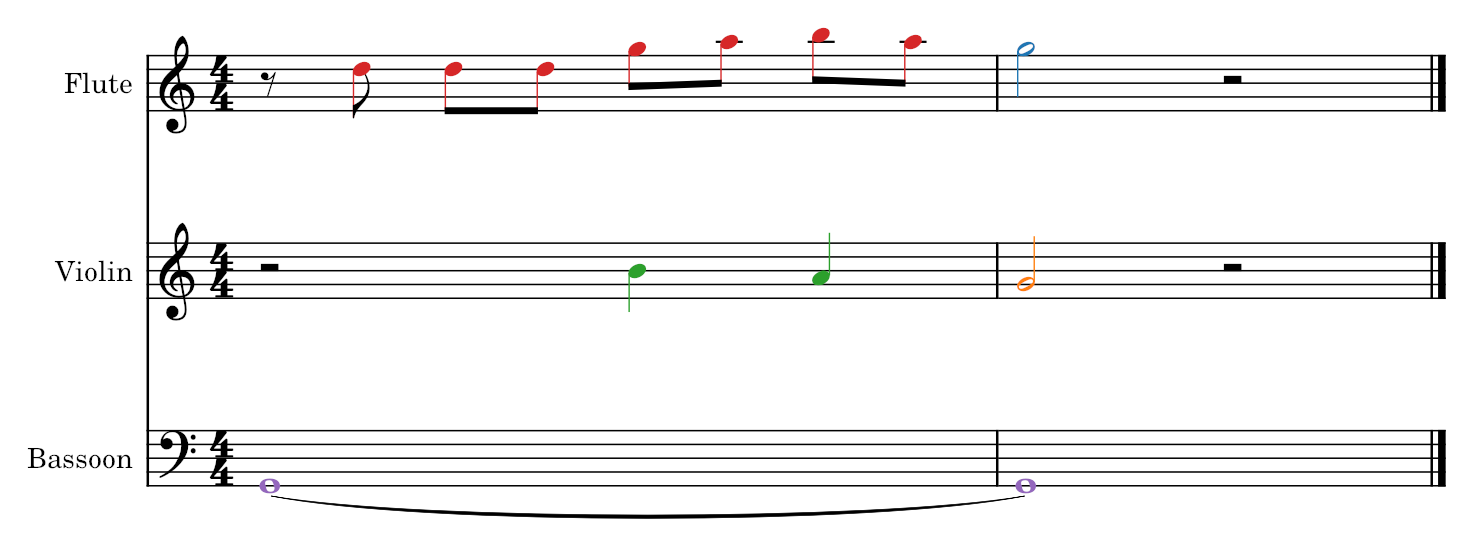

In [3]:
# Toy example score
f1 = T.RED.value
f2 = T.BLUE.value
v1 = T.GREEN.value
v2 = T.ORANGE.value
b1 = T.PURPLE.value

toy = stream.Score()

flute = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g'2 r")
for el in flute.flatten().getElementsByOffset(0.5,3.5):
    el.style.color = f1
for el in flute.flatten().getElementsByOffset(4,5):
    el.style.color = f2
flute.insert(0,instrument.Flute())
toy.insert(0,flute)

violin = converter.parse("tinyNotation: 4/4 r2 b4 a4 g2 r")
for el in violin.flatten().getElementsByOffset(2,3):
    el.style.color = v1
for el in violin.flatten().getElementsByOffset(4,5):
    el.style.color = v2
violin.insert(0,instrument.Violin())
toy.insert(0,violin)

bassoon = converter.parse("tinyNotation: 4/4 GG1~ GG1")
bassoon.insert(0,instrument.Bassoon())
for el in bassoon.flatten().notes:
    el.style.color = b1
toy.insert(0,bassoon)

toy.show(leaveMargin=50)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_trim.png", dpi=300)
#toy.write(fmt="musicxml.png", fp="../Figures/toy.png", dpi=300, leaveMargin=50)

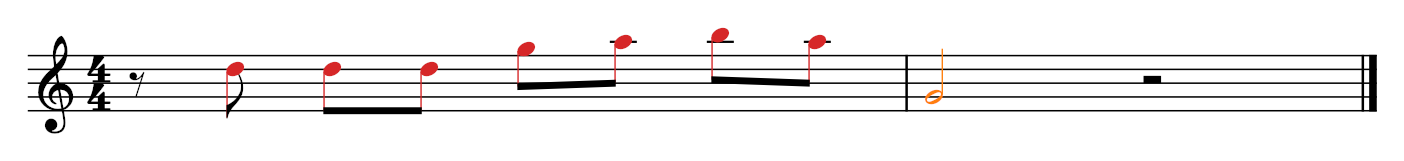

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Figures/toy_arrangement-1.png')

In [ ]:
# Toy selected score
toy = stream.Score()

arrangement = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g2 r")
for el in arrangement.flatten().getElementsByOffset(0.5,3.5):
    el.style.color = f1
for el in arrangement.flatten().getElementsByOffset(4,5):
    el.style.color = v2
toy.insert(0,arrangement)

toy.show(leaveMargin=50)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_arrangement_trim.png", dpi=300)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_arrangement.png", dpi=300, leaveMargin=50)

(np.float64(-1.209829125202103),
 np.float64(1.2082017461745111),
 np.float64(-0.7538426581005653),
 np.float64(0.7553152653763618))

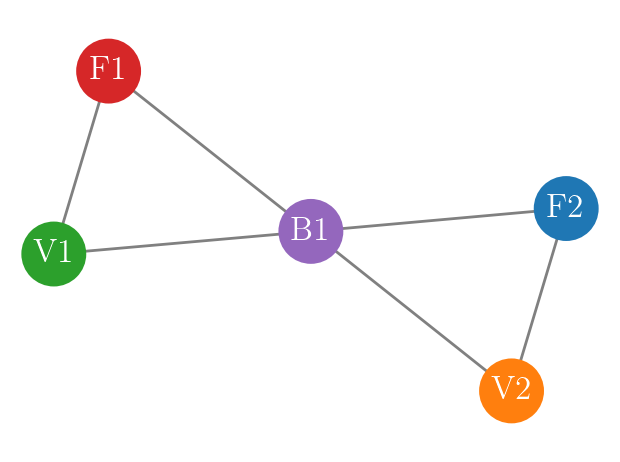

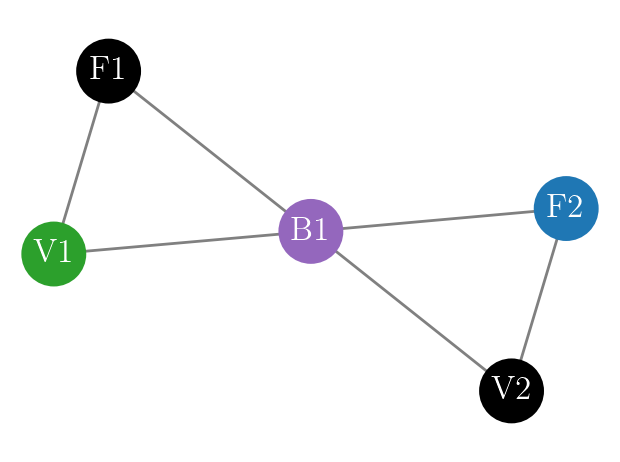

In [4]:
# Toy example graph

edges = [("F1","V1"), ("V1","B1"), ("F1","B1"), ("F2","V2"), ("V2","B1"), ("F2","B1")]

F = nx.Graph()
F.add_edges_from(edges)

colours = [f1, v1, b1, f2, v2]

pos = nx.spring_layout(F, seed=1)
plt.figure(0)
nx.draw_networkx(F, pos=pos, edge_color="gray", width=1, font_color="white", node_size=500, node_color=colours, hide_ticks=True)
plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
#plt.savefig("..\Figures\\toy_graph.svg")

plt.figure(1)
selected = ["F1", "V2"]
nx.draw_networkx(F, pos=pos, edge_color="gray", width=1, font_color="white", node_size=500, node_color=["black",v1,b1,f2,"black"], hide_ticks=True)
plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
#plt.savefig("..\Figures\\toy_solution.pgf")